In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
sys.path.append('../src/scripts')
from multizone_stars import MultizoneStars
from utils import get_bin_centers, get_color_list, weighted_quantile
import vice
from _globals import ZONE_WIDTH, DT, END_TIME

In [62]:
output_name = 'gaussian/insideout/powerlaw_slope11/diskmodel'
mzs = MultizoneStars.from_output(output_name)
multiout = vice.multioutput('../src/data/multizone/' + output_name)

In [88]:
# Range of [Fe/H]
stars = mzs.filter({
    'galr_final': (7, 10), 
    # 'zfinal': (0, 1), 
    'mstar': (1, None), 
    # '[fe/h]': (-1, None),
    'age': (None, 13),
}).stars.copy()
age_bins = np.arange(14)
age_array = get_bin_centers(age_bins)
stars['bin'] = pd.cut(stars['age'], bins=age_bins, include_lowest=True)
grouped = stars.groupby('bin')
# old_feh_range = grouped.quantile(0.95)['[fe/h]'] - grouped.quantile(0.05)['[fe/h]']
# print(old_feh_range)
# mass-weighted quantiles
wq95 = lambda x: weighted_quantile(x, '[fe/h]', 'mass', quantile=0.95)
wq05 = lambda x: weighted_quantile(x, '[fe/h]', 'mass', quantile=0.05)
feh_range = grouped.apply(wq95) - grouped.apply(wq05)
print(feh_range)

bin
(-0.001, 1.0]    0.362260
(1.0, 2.0]       0.455021
(2.0, 3.0]       0.495741
(3.0, 4.0]       0.518896
(4.0, 5.0]       0.537294
(5.0, 6.0]       0.551809
(6.0, 7.0]       0.552312
(7.0, 8.0]       0.553038
(8.0, 9.0]       0.551718
(9.0, 10.0]      0.560747
(10.0, 11.0]     0.590005
(11.0, 12.0]     0.701762
(12.0, 13.0]     1.227189
dtype: float64


In [89]:
# stellar birth [fe/h] gradient
birth_gradients = []
for age_bin in feh_range.index:
    mono_age = stars[stars['bin'] == age_bin].copy()
    # linear regression
    x = mono_age['galr_origin']
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, mono_age['[fe/h]'], rcond=None)[0]
    birth_gradients.append(m)
birth_gradients

[-0.08282717791031328,
 -0.08358476028825429,
 -0.08372194991455584,
 -0.08369043519896564,
 -0.08365824027634605,
 -0.0836763661733789,
 -0.08370234219495522,
 -0.08423436723092367,
 -0.08585435234589263,
 -0.08929826851785251,
 -0.09672903407978281,
 -0.1110643903351586,
 -0.13152189417492136]

In [90]:
# gradient vs range([Fe/H]) linear regression
feh_range_norm = feh_range - feh_range.min()
feh_range_norm /= feh_range_norm.max()
A = np.vstack([feh_range_norm, np.ones(len(feh_range_norm))]).T
m, c = np.linalg.lstsq(A, birth_gradients, rcond=None)[0]
print(m, c)

-0.0567252011881793 -0.07616891251619505


In [91]:
# predict birth gradient
feh_grad_pred = m * feh_range_norm + c

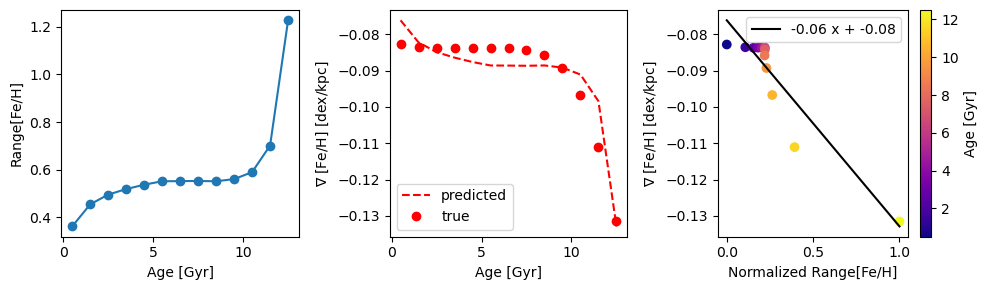

In [92]:
# plot range vs age, gradient vs age, and gradient vs range as in Lu+ (2022) fig A1
fig, axs = plt.subplots(1, 3, figsize=(10, 3), tight_layout=True)

axs[0].plot(age_array, feh_range, 'o-')
axs[0].set_xlabel('Age [Gyr]')
axs[0].set_ylabel('Range[Fe/H]')

axs[1].plot(age_array, feh_grad_pred, 'r--', label='predicted')
axs[1].plot(age_array, birth_gradients, 'ro', label='true')
axs[1].set_xlabel('Age [Gyr]')
axs[1].set_ylabel(r'$\nabla$ [Fe/H] [dex/kpc]')
axs[1].legend()

axs[2].plot([0, 1], [c, m+c], 'k-', label='%.02f x + %.02f' % (m, c))
pc = axs[2].scatter(feh_range_norm, birth_gradients, marker='o', c=age_array, cmap='plasma')
plt.colorbar(pc, ax=axs[2], label='Age [Gyr]')
axs[2].set_xlabel('Normalized Range[Fe/H]')
axs[2].set_ylabel(r'$\nabla$ [Fe/H] [dex/kpc]')
axs[2].legend()
plt.show()

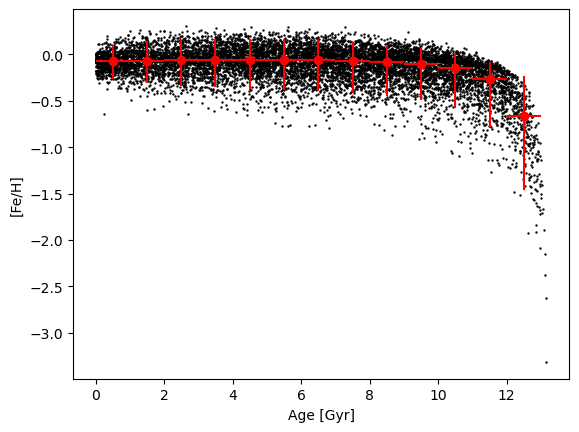

In [93]:
fig, ax = plt.subplots()
sample = mzs.region(galr_lim=(7, 10)).sample(10000)
ax.scatter(sample['age'], sample['[fe/h]'], s=0.5, c='k')
wm = lambda x: weighted_quantile(x, '[fe/h]', 'mass', quantile=0.5)
feh_weighted_median = grouped.apply(wm)
ax.errorbar(age_array, feh_weighted_median, xerr=0.5, 
            yerr=(feh_weighted_median - grouped.apply(wq05),
                  grouped.apply(wq95) - feh_weighted_median),
            fmt='ro')
# ax.scatter(age_array, grouped.max()['[fe/h]'], c='r', marker='x')
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel('[Fe/H]')
plt.show()

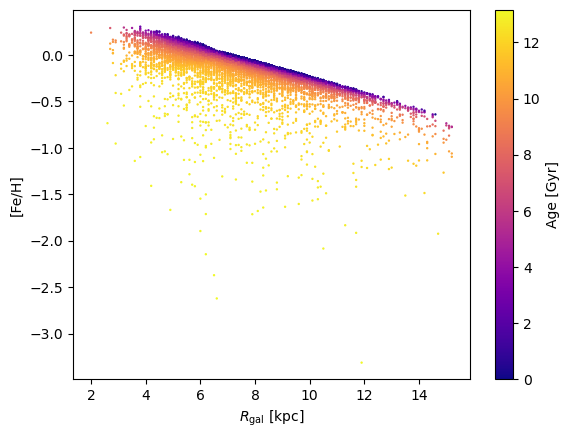

In [97]:
fig, ax = plt.subplots()
sample = mzs.region(galr_lim=(7, 10)).sample(10000)
pc = ax.scatter(sample['galr_origin'], sample['[fe/h]'], c=sample['age'], cmap='plasma', s=0.5)
plt.colorbar(pc, ax=ax, label='Age [Gyr]')
ax.set_xlabel(r'$R_{\rm gal}$ [kpc]')
ax.set_ylabel(r'[Fe/H]')
plt.show()

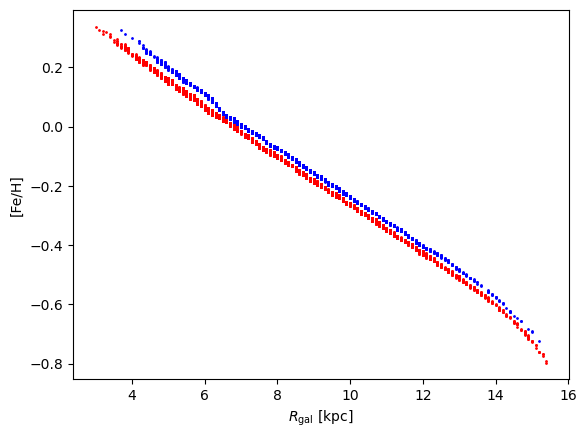

In [99]:
fig, ax = plt.subplots()
sample1 = mzs.filter({'galr_final': (7, 10), 'age': (1, 2), 'mstar': (1, None)}).sample(10000)
pc = ax.scatter(sample1['galr_origin'], sample1['[fe/h]'], c='b', s=1, label='1-2 Gyr')
sample2 = mzs.filter({'galr_final': (7, 10), 'age': (4, 5), 'mstar': (1, None)}).sample(10000)
pc = ax.scatter(sample2['galr_origin'], sample2['[fe/h]'], c='r', s=1, label='4-5 Gyr')
ax.set_xlabel(r'$R_{\rm gal}$ [kpc]')
ax.set_ylabel(r'[Fe/H]')
plt.show()

I think I see a narrowing of the [Fe/H] range, despite the gradient remaining almost identical, because radial migration has carried some of the 5 Gyr old stars farther than the 1 Gyr old stars.

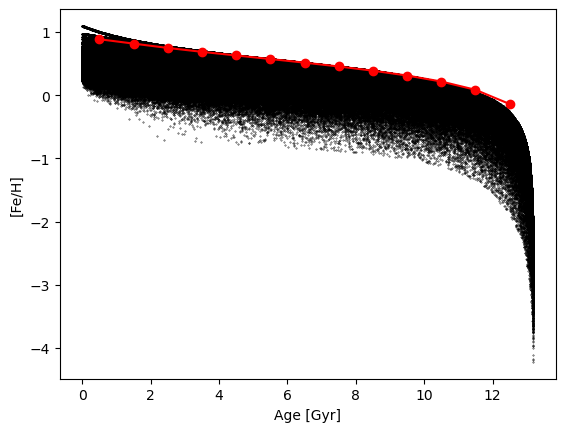

In [52]:
# infer central metallicity time evolution
inner_disk = mzs.region(galr_lim=(0, 5))
inner_disk_stars = inner_disk.stars.copy()
inner_disk_stars['bin'] = pd.cut(inner_disk_stars['age'], bins=age_bins, include_lowest=True)
grouped = inner_disk_stars.groupby('bin')
feh_upper = grouped.quantile(0.95)['[fe/h]']

fig, ax = plt.subplots()
ax.scatter(inner_disk('age'), inner_disk('[fe/h]'), s=0.1, c='k')
age_array = get_bin_centers(age_bins)
ax.plot(age_array, feh_upper, 'ro-')
ax.set_xlabel('Age [Gyr]')
ax.set_ylabel('[Fe/H]')

plt.show()

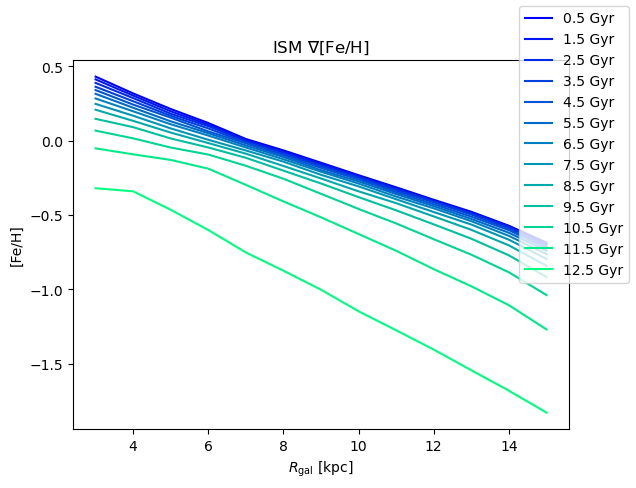

In [55]:
# Measure [Fe/H] radial gradient in the ISM
fig, ax = plt.subplots()

cmap = plt.get_cmap('winter')
colors = get_color_list(cmap, age_bins)

age_array = get_bin_centers(age_bins)
zones = range(30, 155, 10)
Rgal_arr = np.array(zones) * ZONE_WIDTH

true_gradients = []
for i, age in enumerate(age_array):
    feh_zone = []
    for z in zones:
        hist = multiout.zones['zone'+str(z)].history
        int_time = int((max(hist['time'])-age)/DT)
        feh_zone.append(hist['[fe/h]'][int_time])
    feh_zone = np.array(feh_zone)
    ax.plot(Rgal_arr, feh_zone, c=colors[i], label='%s Gyr' % age)
    # linear regression
    A = np.vstack([Rgal_arr, np.ones(len(Rgal_arr))]).T
    m, c = np.linalg.lstsq(A, feh_zone, rcond=None)[0]
    true_gradients.append(m)

ax.set_xlabel(r'$R_{\rm gal}$ [kpc]')
ax.set_ylabel('[Fe/H]')
ax.set_title(r'ISM $\nabla$[Fe/H]')
fig.legend()
plt.show()

In [70]:
# get the metallicity gradient of the galaxy today
zones = range(30, 155, 10)
Rgal_arr = np.array(zones) * ZONE_WIDTH
age = 0
feh_zone = []
for z in zones:
    hist = multiout.zones['zone'+str(z)].history
    int_time = int((max(hist['time'])-age)/DT)
    feh_zone.append(hist['[fe/h]'][int_time])
feh_zone = np.array(feh_zone)
# linear regression
A = np.vstack([Rgal_arr, np.ones(len(Rgal_arr))]).T
m, c = np.linalg.lstsq(A, feh_zone, rcond=None)[0]
feh_gradient_present = m
feh_gradient_present

-0.08989846099012277

In [18]:
# [Fe/H] gradient conversion
grad_slope = -0.08
grad_intercept = feh_gradient_present
# normalized [Fe/H] range
feh_range_norm = feh_range - feh_range.min()
feh_range_norm /= feh_range_norm.max()
feh_birth_grad = grad_slope * feh_range_norm + grad_intercept

NameError: name 'feh_gradient_present' is not defined